# Recurrent Neural Network

**RNNs** are deep learning models that capture the dynamics of sequences via *recurrent* connections (cycles in the network of nodes). They have advantages of flexibility in handling data of varying length and the ability to make sequential predictions useful for NLP, time-series analysis and video analysis.

Conventional machine learning models have concerned with single feature vector $x\in\mathbb{R^d}$ of fixed length $d$. RNN and relevant ideas are capable of processing sequence of data, namely an ordered list of feature vectors, $x_1, ..., x_T$, where each feature vector $x_i$ is indexed with a time step $t\in \mathbb{Z}^+$. 

Though the entire sample data is drawn from a hypothetical distribution, we do not assume that adjacent feature vectors are independent from each other. Model type varies based on the actual structure of the observations and targetes. **Aligned** model make a prediction for each input, while **unaligned** model may predict a sequence of target from one input or one target for a sequence of data. 

##  Autoregressive Model
Given the historical data $x_1,..,x_{t-1}$, we are interested in $P(x_t|x_1,...,x_{t-1})$. We may focus on the summary statistics $E[P(x_t|x_1,...,x_{t-1})]$. Based on the belif of unneccessity to trace back the history to far, we define some $\tau\in \mathbb{Z}^+$ and focus on $x_{t-\tau}, ...,x_{t-1}$. The model also creates some latent summary statistics $h_t$ of the past observations. Then,$\hat x_t = P(x_t | h_t)$ and $h_t = g(h_{t-1}, x_{t-1})$.

## Sequence Model

When working with discrete data, we wish to estimate the joint probability of an entire sequence. Sequence model is identical to the autoregressive model since
$$
P(x_1,...X_T) = P(x_1)\prod^T_{t=2}P(x_t|x_{t-1},...,x_1)
$$


## Markov Model

Whenever keeping only recent data in time $\tau$ does lose predictive power, we say that the sequence satisfies a *Markov coondition*, and call it $\tau$-th order Markov model. Then, a markov model is a simplified sequence model.

## Markov Model Example:

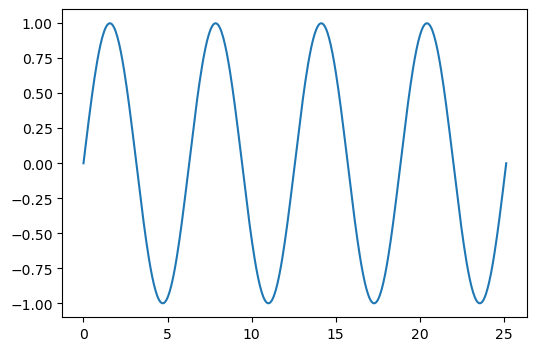

In [35]:
import torch
import dl
import matplotlib.pyplot as plt
import numpy as np

TAU = 4
class CosineData(dl.DataModule):
    def __init__(self, batch_size=32, T=500, num_train=300, tau=4):
        self.save_hyperparameters()
        self.time = np.linspace(0, 8*np.pi, T)
        self.x = torch.sin(torch.tensor(self.time))

    def get_dataloader(self, train=True):
        if train:
            indices = list(range(0, self.num_train-self.tau-1, 1))
        else:
            indices = list(range(self.num_train, self.time.shape[0]-self.tau-1, 1))

        yield (
            torch.stack([self.x[offset:indices[-1]+offset] for offset in range(self.tau)], dim=1),
            self.x[self.tau:]
        )

data = CosineData(tau=TAU)
plt.plot(data.time, data.x);

In [36]:
class LinearRegression(dl.Module):
    def __init__(self, P, eta, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(P, 4, dtype=torch.float64)
            torch.nn.Linear(4, 1, dtype=torch.float64)
            )

        torch.nn.init.xavier_normal_(self.net[0].weight)

    def loss(self, y_hat, y):
        l = (y_hat - y) ** 2
        return l.mean()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3095436046.py, line 6)

In [37]:
trainer = dl.Trainer(50)
model = LinearRegression(TAU, 0.01)
trainer.fit(model, data)
trainer.plot_loss()

RuntimeError: expected scalar type Float but found Double

### Intrapolation

RuntimeError: expected scalar type Float but found Double

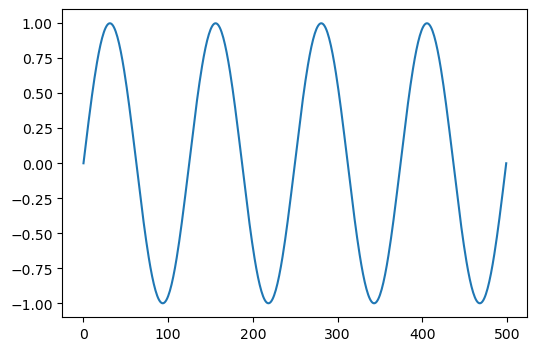

In [38]:
plt.plot(
    data.x
)
x_hat = torch.concat([model(X) for X,y in data.get_dataloader()]).detach().numpy().flatten()
plt.plot(x_hat)

Thus, a simple linear regression fit the noisy training cosine curve reasonably well although it also fit the noise. Now we observe how it generalizes to the unseen data. Notice that the model relies on $x$ to predict $\hat x$. Thus, the technique for making successive prediction is
$$\hat x_t = f(\hat x_{t-\tau-1}, ...,\hat x_{t-1})$$

### Extrapolation

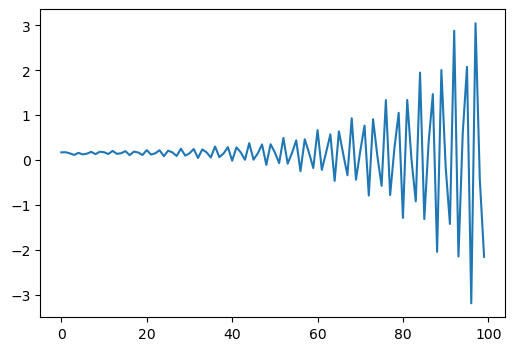

In [23]:
x = torch.tensor(x_hat[-TAU:]).reshape(1,-1)
x_hat_future = []
for n in range(100):
    output = model(x)
    x_hat_future.append(output.item())
    x = torch.tensor(list(x.numpy()[0])[-TAU+1:] + [output.item()]).reshape(1,-1)
plt.plot(range(len(x_hat_future)), x_hat_future);

Observe that without input data, the model is capable of capturing the overall trend. The dramatic deviation from the actual curve is due to the accumulation of error terms as $T$ grows.

## Recurrent Neural Network

Recurrent neural network refers to layer that feed in a summary information of previous observations to make the current prediction. At time step $t$, the network maintains a fixed function to compute the hidden state $h_t$. For a minibatch examples $X\in\mathbb{R}^{n\times d}$, the hidden layer output $H\in\mathbb{R}^{n\times h}$ is calculated as 
$$
H_t = \phi(X_tW_{xh} + H_{t-1}W_{hh} + b_h)
$$
Next, using the hidden state, we can make prediction by
$$
O_t = H_tW_{hq} + b_q
$$
similar to regular MLP.

**Remark**: The calculation of $X_tW_{xh} + H_{t-1}W_{hh}$ is equivalent to $ concat(X_t, H_{t-1}) \times concat(W_{xh}, W_{hh})$. (not proven)

**Remark**: In order to exploit the full potential of the hidden states, an entire sequence should be fed into the model. RNN would fail to extrapolate if trained on a segment of the sequence.

In [145]:
class RNN_hidden(dl.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        # Recurrent Layer
        self.W_xh = torch.nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = torch.nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = torch.nn.Parameter(torch.randn(num_hiddens))
        
    def forward(self, X, state):          

        return torch.sigmoid(X@self.W_xh + state@self.W_hh + self.b_h)

class RNN(dl.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = RNN_hidden(num_inputs, num_hiddens, sigma)
        self.W_hq = torch.nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b_q = torch.nn.Parameter(torch.randn(1))

        self.state = None

    def forward(self, seq, state=None):
        self.state = state if state is not None else torch.zeros((self.num_inputs, self.num_hiddens), device=seq.device)  
                        
        output = []
        for X in seq:
            self.state = self.rnn(X, self.state)
            output.append(self.state@self.W_hq + self.b_q)

        return torch.stack(output)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), 0.01)

    def loss(self, y_hat, y):
        l = torch.nn.MSELoss()
        return l(y_hat.flatten(), y)

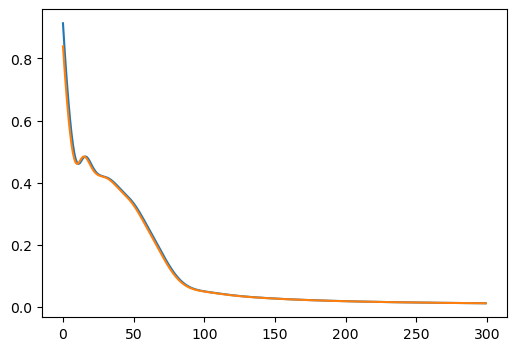

In [146]:
@dl.add_to_class(CosineData)
def get_dataloader(self, train=True):
    yield train_x, train_y

look_back = 130
model = RNN(1, 10, 1)
data = CosineData()
trainer = dl.Trainer(300)
trainer.fit(model, data)
trainer.plot_loss()

### Intrapolation

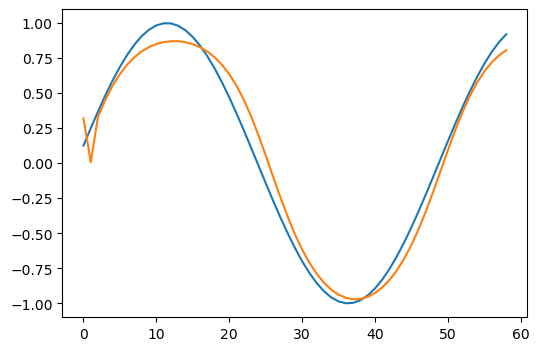

In [147]:
state = None
output = []
plt.plot(train_y.flatten())
for X in train_x:
    pred = model(X.reshape(-1,1), state)
    state = model.state
    output.append(pred.item())

plt.plot(output);

### Extrapolation

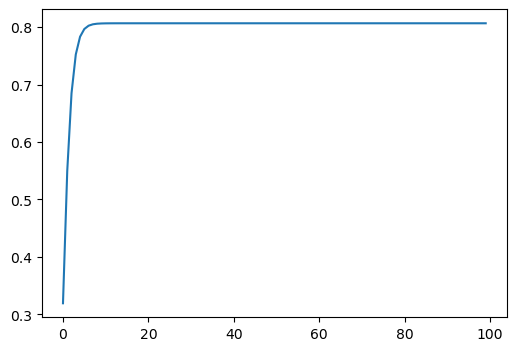

In [148]:
x = train_x[0].clone().reshape(-1,1)
state = 0 
output = []
with torch.no_grad():
    for i in range(100):
        x = model(x)
        output.append(x.item())
    plt.plot(output)

In [149]:
def generate_sinus_wave(train_len, valid_len):
    time_steps = np.linspace(0, 8*np.pi, train_len+valid_len)
    data = np.sin(time_steps)

    xs = data[:train_len-1]
    ys = data[1:train_len] # as discussed in class, targets are shifted by 1 step

    train_x = torch.Tensor(xs).view(-1, 1, 1)
    train_y = torch.Tensor(ys)
    return data, time_steps, train_x, train_y

seq_length = 200 #total sequence length
portion_train = 0.3 #portion of the sequence length used for training

train_len = int(seq_length*portion_train)
valid_len = seq_length-train_len
data, time_steps, train_x, train_y = \
    generate_sinus_wave(train_len = train_len, valid_len = valid_len)

train_x.shape

torch.Size([59, 1, 1])

In [150]:
model = RNN(1, 8, 1) # first we instantiate our model

criterion = torch.nn.MSELoss() # we are using means squered error as loss function here
# this will set-up an optimizer for parameter updates, feel free to ignore this for now!
optimizer = torch.optim.Adam(model.parameters(), 0.01)

epochs = 300 # one epoch corresponds to a single pass through the entire training data
for epoch in range(epochs):
    optimizer.zero_grad()
    
    output = model(train_x)
    loss = criterion(output.view(-1), train_y)
    loss.backward()
    optimizer.step()

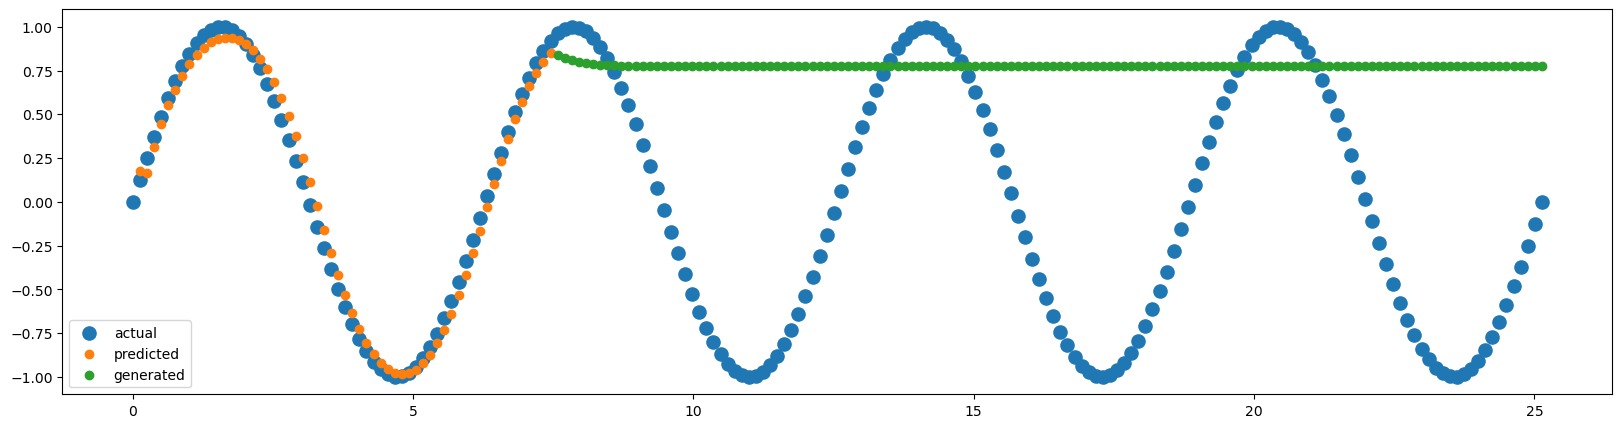

In [151]:
import time


def make_predictions_train(model):
    predictions = []
    hidden_prev = None
    # we will go over all points in out training sequence
    for i in range(train_x.shape[0]):
        input = train_x[i]
        input = input.view(1, 1, 1)
      
        # we will give the current (single) point and the (current) 
        # hidden state as input to our model
        
        # we carry over the previous hidden state
        pred, hidden_prev = model(input, hidden_prev), model.state.clone()
        predictions.append(pred.data.numpy()[0][0])
    return predictions, hidden_prev

predictions_train, hidden_prev = make_predictions_train(model)

def generate_unseen_sequence(model, length, starting_point, hidden_state):
    predicts=[]
    input = torch.Tensor(starting_point).view(1,1,1)
    for i in range(length):
        pred, hidden_state = model(input, hidden_state), model.state
        predicts.append(pred.data.numpy()[0][0])
        input = pred
    return predicts

generated_points = generate_unseen_sequence(model, valid_len, starting_point=predictions_train[-1], hidden_state=hidden_prev)

predictions = predictions_train+generated_points #concatenate two lists

#plot
fig, ax = plt.subplots(figsize=(20,5))
plt.scatter(time_steps, data, s=90, label='actual')
plt.scatter(time_steps[1:train_len], predictions[:train_len-1], label='predicted')
plt.scatter(time_steps[train_len:], predictions[train_len-1:], label='generated')
ax.legend()

As the result above suggests, a depth-2 recurrent neural network is able to fit a sine function and maintain a good extrapolation accuracy, which outperforms a simple regression model. However, a MLP with identity activation function can achieve equally good result in modeling certain functions. 

See 
- https://ai.stackexchange.com/questions/36488/entirely-linear-neural-network-learning-non-linear-function/36489#36489
- https://www.kaggle.com/code/seangribben/lstm-time-series-prediction-pytorch-sine-wave/notebook

## Gradient Clipping

## Backpropagation Through Time